In [1]:
%matplotlib notebook
import sys
print (sys.path)


Bad key "text.kerning_factor" on line 4 in
/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


['/g/wsl_projs/practical-astronomy/notebooks', '/home/anybody/wsl_projs/practical-astronomy', '/home/anybody/wsl_projs/example', '/g/wsl_projs/practical-astronomy/notebooks', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python37.zip', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/lib-dynload', '', '/home/anybody/.local/lib/python3.7/site-packages', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages', '/home/anybody/.local/lib/python3.7/site-packages/IPython/extensions', '/home/anybody/.ipython']


In [2]:
import sys
from pathlib import Path

SRC_ROOT_DIR_0 = '/g/wsl_projs/practical-astronomy'
SRC_ROOT_DIR_1 = '/g/wsl_projs/practical-astronomy/myastro/'
sys.path.insert(0, SRC_ROOT_DIR_0)
sys.path.insert(1, SRC_ROOT_DIR_1)

%load_ext autoreload
%autoreload 2

In [9]:
import myastro.timeutil as tc
import myastro.coord as co
import myastro.orbit as ob
import numpy as np
from toolz import pipe, compose, keyfilter
import toolz as tz
from functools import partial
from itertools import starmap
from myastro.data_catalog import DF_BODYS, DF_COMETS, DF_PLANETS, read_body_elms_for, read_comet_elms_for, BodyElems
from matplotlib import pyplot
from numpy.linalg import norm
from myastro.util import pow
import myastro.util as ut


In [4]:
print (sys.path)

['/g/wsl_projs/practical-astronomy', '/g/wsl_projs/practical-astronomy/myastro/', '/g/wsl_projs/practical-astronomy/notebooks', '/home/anybody/wsl_projs/practical-astronomy', '/home/anybody/wsl_projs/example', '/g/wsl_projs/practical-astronomy/notebooks', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python37.zip', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/lib-dynload', '', '/home/anybody/.local/lib/python3.7/site-packages', '/home/anybody/apps/anaconda3/envs/py37astro/lib/python3.7/site-packages', '/home/anybody/.local/lib/python3.7/site-packages/IPython/extensions', '/home/anybody/.ipython']


In [5]:
from itertools import repeat

In [6]:
lat = 40
dec = -10
hour_angles = np.linspace(-12, 12, 24)
# a list of tuples is generated
tups = map(co.equat2horiz,repeat(lat,24),hour_angles, repeat(dec,24))
# two list of singles valures are generated and after that they are converted to rad.
elevation, azimuth = map(np.deg2rad,map(np.array, zip(*tups)))

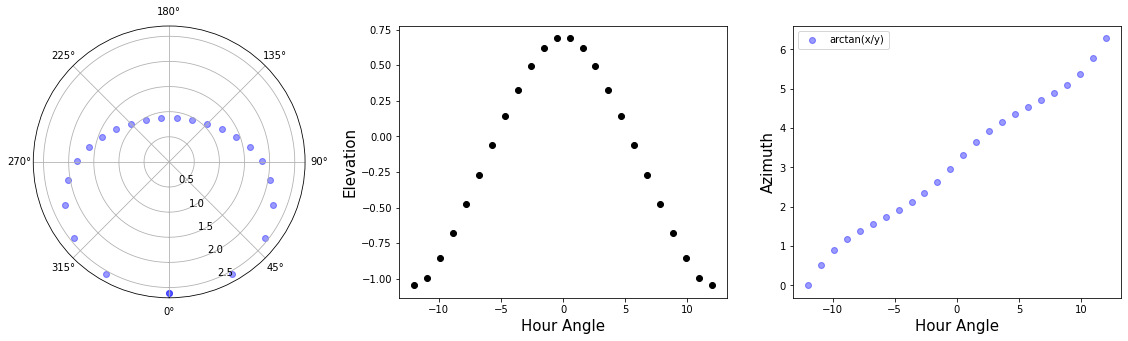

In [7]:
fig = pyplot.figure(figsize=(20,5))
axes1= fig.add_subplot(131, polar = True)
axes2= fig.add_subplot(132)
axes3= fig.add_subplot(133)

axes1.scatter(azimuth, np.pi/2 - elevation, c='b', label = "arctan(x/y)", alpha = 0.4)
axes1.set_theta_zero_location('S')

axes2.scatter(hour_angles, elevation, c='k')
axes3.scatter(hour_angles, azimuth, c='b', label = "arctan(x/y)",  alpha = 0.4)

axes2.set_xlabel("Hour Angle", fontsize = 15)
axes3.set_xlabel("Hour Angle", fontsize = 15)

axes2.set_ylabel("Elevation", fontsize = 15)
axes3.set_ylabel("Azimuth", fontsize = 15)


pyplot.legend()
pyplot.savefig("comparing_arctan_arctan2.png")

pyplot.show()

In [8]:
from numpy.random import default_rng
rng = default_rng()
rnd_ab = lambda n,a,b : (b-a)*rng.random((n,))+a


<IPython.core.display.Javascript object>


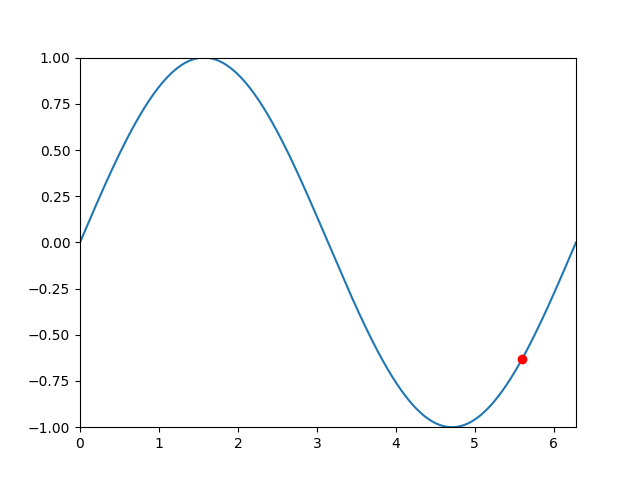

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
s = np.sin(t)
l = plt.plot(t, s)

ax = plt.axis([0,TWOPI,-1,1])

redDot, = plt.plot([0], [np.sin(0)], 'ro')

def animate(i):
    redDot.set_data(i, np.sin(i))
    return redDot,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0.0, TWOPI, 0.1), \
                                      interval=10, blit=True, repeat=True)

plt.show()

<IPython.core.display.Javascript object>


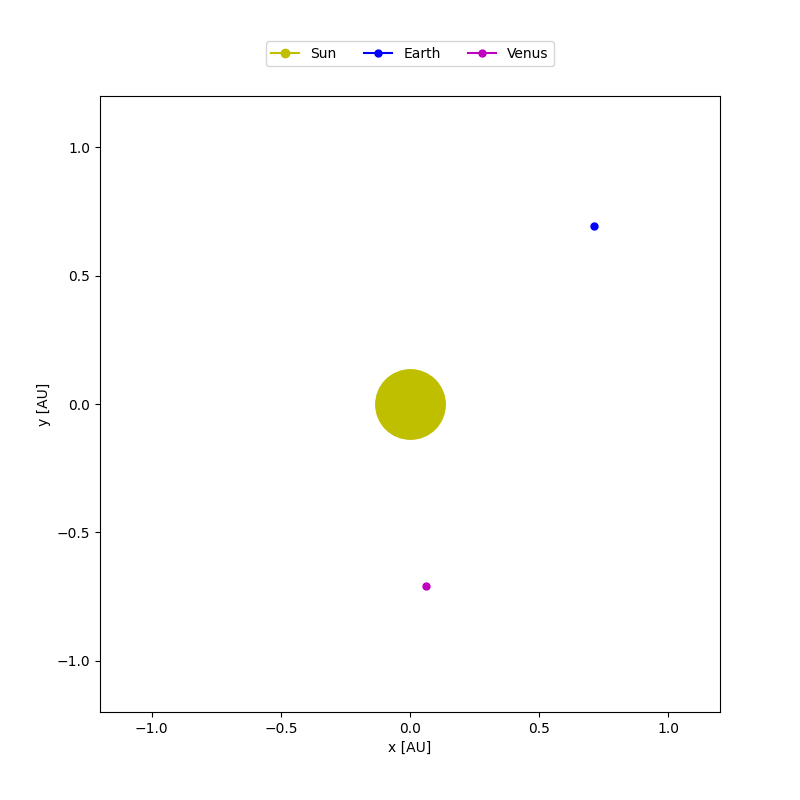

In [7]:
import numpy
import math
import pylab
import matplotlib.animation as animation
from matplotlib.font_manager import FontProperties

G = 6.67428e-11 # Newton's gravitational constant
AU = (149.6e6 * 1000) # Astronomical unit in metres
timestep = 24 * 3600 # One day in seconds (timestep for the simulation)

class planet(object):
    """
    Planet class.
    Contains information about the planet's
    current position, velocity and mass
    and other general information.
    """

    def __init__(self):
        self.px = 0.0
        self.py = 0.0
        self.vx = 0.0
        self.vy = 0.0
        self.mass = None
        self.color = None
        self.size = None
        self.name = None

    def compute_force(self, others):
        """
        Compute the total exerted force on the
        body at the current moment.
        """
        self.total_fx = self.total_fy = 0.0
        for other in others:
            # Compute the distance of the other body.
            sx, sy = self.px, self.py
            ox, oy = other.px, other.py
            dx = (ox-sx)
            dy = (oy-sy)
            d = numpy.sqrt(dx ** 2 + dy ** 2)

            # Compute the force of attraction
            f = G * self.mass * other.mass / (d ** 2)

            # Compute the direction of the force.
            theta = math.atan2(dy, dx)
            fx = math.cos(theta) * f
            fy = math.sin(theta) * f

            # Add to the total force exerted on the planet
            self.total_fx += fx
            self.total_fy += fy

    def update_position(self):
        """
        Update particle velocity and position based on the
        current exterted total force on the body.
        """
        self.vx += self.total_fx / self.mass * timestep
        self.vy += self.total_fy / self.mass * timestep
        self.px += self.vx * timestep
        self.py += self.vy * timestep

def animate(i, bodies, lines):
    """
    Animation function. Updates the
    plot on each interation.
    """
    for ind, body in enumerate(bodies):
        body.compute_force(numpy.delete(bodies, ind))
    for body in bodies:
        body.update_position()
    for i in range(len(bodies)):
        lines[i].set_data(bodies[i].px / AU, bodies[i].py / AU)
    return lines


Sun = planet() # Instance of planet Sun
Earth = planet() # Instance of planet Earth
Venus = planet() # Instance of planet Venus

Sun.mass = 1.98892 * 10 ** 30
Sun.color = 'y'
Sun.size = 50
Sun.name = 'Sun'
Earth.mass = 5.9742 * 10 ** 24
Earth.px = -1 * AU
Earth.vy = 29.783 * 1000
Earth.color = 'b'
Earth.size = 5
Earth.name = 'Earth'

Venus.mass = 4.8685 * 10 ** 24
Venus.px = 0.723 * AU
Venus.vy = -35.02 * 1000
Venus.color = 'm'
Venus.size = 5
Venus.name = 'Venus'

bodies = [Sun, Earth, Venus]
lines = [None] * len(bodies)
fig = pylab.figure(figsize=(8,8))
ax = pylab.subplot()

for i in range(len(bodies)):
    lines[i], = ax.plot(bodies[i].px / AU, bodies[i].py / AU,
    marker='o', color=bodies[i].color, ms=bodies[i].size,
    label=bodies[i].name)

ani = animation.FuncAnimation(fig, animate, numpy.arange(1, 500),
    fargs=[bodies, lines], interval=20, blit=True, repeat=True)

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
legend = ax.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
legend.legendHandles[0]._legmarker.set_markersize(6)
plt.show()


In [35]:
print (pipe(dec,tc.deg2degms))

(27.0, 7.0, 40.89749596844456, 1)


In [10]:
from visual import *

G = 6.7e-11

giant = sphere(pos=(-1e11,0,0), radius=2e10, color=color.red,
               make_trail=True, interval=10)
giant.mass = 2e30
giant.p = vector(0, 0, -1e4) * giant.mass

dwarf = sphere(pos=(1.5e11,0,0), radius=1e10, color=color.yellow,
               make_trail=True, interval=10)
dwarf.mass = 1e30
dwarf.p = -giant.p

dt = 1e5

while True:
  rate(200)

  dist = dwarf.pos - giant.pos
  force = G * giant.mass * dwarf.mass * dist / mag(dist)**3
  giant.p = giant.p + force*dt
  dwarf.p = dwarf.p - force*dt

  for star in [giant, dwarf]:
    star.pos = star.pos + star.p/star.mass * dt

ModuleNotFoundError: No module named 'visual'

In [4]:
sol1 = np.array([[1,2,3,4], [11,12,13,14], [21,22,23,24]])
sol2 = np.array([[31,32,33,34], [41,42,43,44], [51,52,53,54]])

In [5]:
sol1

array([[ 1,  2,  3,  4],
       [11, 12, 13, 14],
       [21, 22, 23, 24]])

In [8]:
sol1[:,-1][:3]

array([ 4, 14, 24])

In [20]:
np.concatenate((sol1,sol2),axis=1)

array([[ 1,  2,  3,  4, 31, 32, 33, 34],
       [11, 12, 13, 14, 41, 42, 43, 44],
       [21, 22, 23, 24, 51, 52, 53, 54]])

In [21]:
t1= np.array([1,2,3,4])
t2= np.array([5,6,7,8])
np.concatenate((t1,t2))

array([1, 2, 3, 4, 5, 6, 7, 8])

In [22]:
t1.shape

(4,)

In [14]:
d = dict()
d[10] = np.array([1,2,3])
d[11] = np.array([4,5,6])
d[12] = np.array([7,8,9])
#d = {10:np.array([1,2,3], 11:np.array([4,5,6]) , 12:np.array([7,8,9])}



In [16]:
np.column_stack(list(d.values()))

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [19]:
np.array(list(d.keys()))

array([10, 11, 12])

In [27]:
a_dictionary = {7: ("a","a"), 4: ("b","b"), 1: ("c","c")}
#a_dictionary = sorted(a_dictionary.keys())
#print (type(a_dictionary))


In [28]:
a_dictionary = {k:a_dictionary[k] for k in sorted(a_dictionary.keys())}

In [29]:
a_dictionary

{1: ('c', 'c'), 4: ('b', 'b'), 7: ('a', 'a')}

In [30]:
keyfilter(lambda t: (3<t) and (t<5), a_dictionary)

{4: ('b', 'b')}

In [ ]:
>>> iseven = lambda x: x % 2 == 0
>>> d = {1: 2, 2: 3, 3: 4, 4: 5}
>>> keyfilter(iseven, d)
{2: 3, 4: 5}

In [31]:
a = [1,2,3,4,5]
print (a[0:-1])

[1, 2, 3, 4]


In [33]:
np.diff(a)

array([1, 1, 1, 1])

In [36]:
DF_BODYS.head()

,Name,Epoch,a,e,i,w,Node,M,H,G,Ref
1,Ceres,59000.0,2.767657,0.077557,10.58862,73.73167,80.28699,162.686252,3.40,0.12,JPL 46
2,Pallas,59000.0,2.773841,0.229972,34.83293,310.20239,173.02474,144.975678,4.20,0.11,JPL 36
3,Juno,59000.0,2.668285,0.256936,12.99104,248.06619,169.85148,125.435354,5.33,0.32,JPL 111
4,Vesta,58600.0,2.361418,0.088721,7.14177,150.72854,103.81080,95.861938,3.00,0.32,JPL 35
5,Astraea,59000.0,2.574037,0.190913,5.36743,358.64842,141.57103,17.846339,6.90,0.15,JPL 113


In [37]:
for name in DF_BODYS['Name'].head():
    print (name)

Ceres
Pallas
Juno
Vesta
Astraea


In [38]:
len(DF_BODYS)

498

In [4]:
r = np.array([6524.834, 6862.875, 6448.296])
v = np.array([4.901327, 5.533756, -1.976341])
h = np.cross(r,v)

In [5]:
h

array([-49246.67792015,  44500.50424119,   2469.64476138])

In [6]:
print (norm(h))

66420.09717802519


In [7]:
K = np.array([0,0,1])
n = np.cross(K,h)
n

array([-44500.50424119, -49246.67792015,      0.        ])

In [17]:
km_m = 1000
def to_km_seconds(mu_m3s_2):
    return mu_m3s_2/pow(km_m,3)
# For earth
mu = to_km_seconds(ut.mu_m3s_2__by_name["Earth"])

In [46]:
e_v = ((pow(norm(v),2) - mu/norm(r))*r - r.dot(v)*v)/mu
e = norm(e_v)
xi = pow(norm(v),2)/2 - (mu/norm(r))
a = - mu/(2*xi)
p = pow(norm(h),2)/mu
i = np.rad2deg(np.arccos(h[2]/norm(h)))
Omega = np.rad2deg(np.arccos(n[0]/norm(n)))
if n[1] < 0 :
    Omega = 360 - Omega
Omega
omega = np.rad2deg(np.arccos(n.dot(e_v)/(norm(n)*norm(e_v))))
omega
M = np.rad2deg(np.arccos(e_v.dot(r)/(norm(e_v)*norm(r))))
M






92.33584244533552

In [35]:
norm(n)

66374.16789603393